# ASL Sign Language Detection Using ViT

### Relevant Imports

In [1]:
import os
import csv
import pandas as pd
import numpy as np
from skimage import io
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import math


import torch
from torch import nn, Tensor
from torch.utils import data as tdata
from torchvision import utils as vutils, transforms as T
from torchvision.datasets import ImageFolder

from transformers import ViTImageProcessor
import pytorch_lightning as pl

In [2]:
random_seed = 42
pl.seed_everything(random_seed)

# as we can see the above sets the seed for everything. this produces 51 each time
np.random.randint(0, 100)

Global seed set to 42


51

In [3]:
image_processor = ViTImageProcessor()
image_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [4]:
train_path = './data/asl_alphabet_train/asl_alphabet_train/'
mean, std = image_processor.image_mean, image_processor.image_std
img_size = image_processor.size["height"]

In [5]:
# train_transforms = T.Compose([
#     T.ToTensor(),
#     T.Resize((img_size, img_size)),
#     T.Normalize(mean, std)
# ])

# valid_transforms = T.Compose([
#     T.ToTensor(),
#     T.Resize((img_size, img_size)),
#     T.Normalize(mean, std)
# ])

### Implementing a Custom Dataset

- We could just use `ImageFolder` to read images, but due to the initial high cost of it. We will only be using it during final training.
- For all other uses we will be implementing a custom dataset to make setup faster.

In [1]:
# train_dataset = ImageFolder(kaggle_train_path, transform=data_transforms)
# train_dataset[0]

In [6]:
def get_dirs(root_path):
    """
        Returns `(list_classes, classes_to_idx, numpy array mapping path to class_idx)
    """
    if not os.path.exists(root_path):
        raise FileNotFoundError("Folder does not exist")
        
    classes = sorted(os.listdir(root_path))
    classes_to_idx = {c: i for i, c in enumerate(classes)}
    
    all_samples = []
    
    for idx, cl in enumerate(classes):
        path = os.path.join(root_path, cl)
        
        all_files = os.listdir(path)
        
        # add `(path, class_idx)` to all_samples
        all_samples.extend([[p, idx] for p in all_files])

    all_samples = np.array(all_samples)
    
    return classes, classes_to_idx, all_samples
    
all_classes, classes_to_idx, all_samples = get_dirs(train_path)

In [7]:
print(f"Number of samples: {len(all_samples)}")
train_ratio = 0.8
train_samples, test_samples = train_test_split(all_samples, shuffle=True, train_size=train_ratio, random_state=random_seed)
print(f"Length of splits: {len(train_samples)}, {len(test_samples)}")
train_samples[0], test_samples[0]

Number of samples: 87000
Length of splits: 69600, 17400


(array(['X2342.jpg', '23'], dtype='<U15'),
 array(['T964.jpg', '19'], dtype='<U15'))

In [19]:
class CustomDataset(tdata.Dataset):
    
    def __init__(self, root_path, samples, classes, transform=None, transform_args=[]):
        """_summary_

        Args:
            root_path (_type_): path from where data will be read. Like `ImageFolder`, pass in folder path where folders inside it will be treated as classes.
            samples (_type_): a numpy array that will have rows that map `(image_path, class_idx)`
            classes (_type_): a list of all class names
            transform (_type_, optional): If provided, can be torch transforms or 🤗 image processors. Defaults to None.
            transform_args (list, optional): Is a list of `(argument, value)`. Defaults to [].
        """
        
        self.root_path = root_path
        self.samples = samples
        self.transform = transform
        self.classes = classes

        self.transform_args = {}
        for key, val in transform_args:
            self.transform_args[key] = val
        
        print(self.transform_args)
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        file_name, target = self.samples[idx]
        target = int(target)
        file_path = os.path.join(self.root_path, self.classes[target], file_name)
        
        img = io.imread(file_path)
        
        if self.transform is not None:
            img = self.transform(img, **self.transform_args)
        
        return img["pixel_values"][0], target

We will be using the 🤗 `ViTImageProcessor` to perform the basic transforms.

In [20]:
transform_args = [("return_tensors", 'pt')]

train_dataset = CustomDataset(
    train_path, train_samples, all_classes, transform=image_processor, transform_args=transform_args)
valid_dataset = CustomDataset(train_path, test_samples, all_classes,
                              transform=image_processor, transform_args=transform_args)
len(train_dataset), len(valid_dataset)


{'return_tensors': 'pt'}
{'return_tensors': 'pt'}


(69600, 17400)

In [21]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

### Defining utilities to plot images

In [22]:
def denorm(tensor, mean=mean, std=std):
  """This denormalises the tensor so that we can use it to plot normalised images"""
  mean, std = torch.tensor([mean]), torch.tensor([std])
  # print(mean.shape)
  output = std * tensor + mean
  return torch.clamp(output, 0, 1)

In [23]:
def plot_image(tensor, label=None, denormalise=True):
  """tensor is of shape `(h, w, c)`"""
  plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

  if label is not None:
    plt.title(str(label))
  
  if denormalise:
    tensor = denorm(tensor)
    tensor.permute(1, 2, 0)
    
  plt.imshow(tensor)

In [24]:
def plot_grid(tensor, n_row):
  """Input is of shape (batch_size, c, h, w)"""

  grid_tensor = vutils.make_grid(tensor, n_row).permute(1, 2, 0)
  plot_image(grid_tensor, "Grid of Random ASL Images")

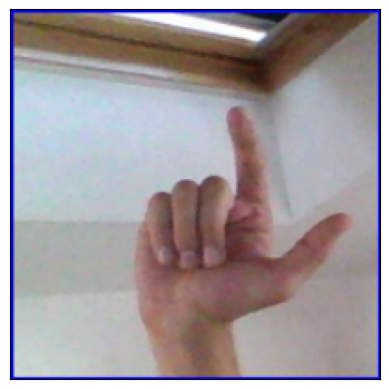

In [25]:
# img = image_processor(train_dataset[1][0], return_tensors='pt')["pixel_values"][0].permute(1, 2, 0)
img = train_dataset[1][0].permute(1, 2, 0)
plot_image(img)

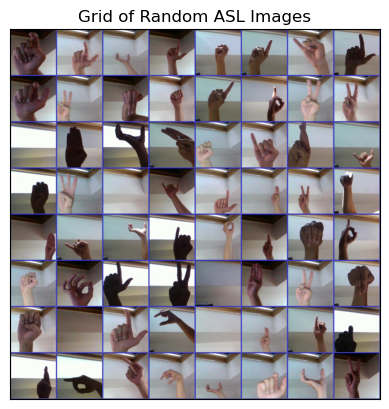

In [31]:
from torch.utils.data import BatchSampler, SequentialSampler

batch_size = 64

batch_sampler = BatchSampler(SequentialSampler(train_dataset), batch_size, drop_last=False)
train_loader = tdata.DataLoader(train_dataset, batch_sampler=batch_sampler)

for images, labels in train_loader:
    plot_grid(images, 8)
    break

### Defining the training process

In [ ]:
class Accumulator:
  """For accumulating sums over `n` variables."""

  def __init__(self, n):
    """Defined in :numref:`sec_utils`"""
    self.data = [0.0] * n

  def add(self, *args):
    self.data = [a + float(b) for a, b in zip(self.data, args)]

  def reset(self):
    self.data = [0.0] * len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

In [ ]:
def get_correct(predictions: Tensor, labels: Tensor):
  if len(labels.shape) > 1:
    labels = labels[:, 0]

  predictions = predictions.max(dim=-1).indices
  return (predictions == labels).to(torch.int32).sum().item()

In [ ]:
def train_per_epoch(images, labels, model, loss, optimizer):
  """
    Returns `(num_correct, loss, len_batch)`
  """


  # get number of instances
  len_batch = len(images)

  predictions = model(images)
  num_correct = get_correct(predictions, labels)
  l = loss(predictions, labels)

  optimizer.zero_grad()
  l.backward()

  optimizer.step()

  return num_correct, l, len_batch

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
from tqdm import trange


def train(train_loader, num_epochs, model, loss, optimizer, device=device):
  """
    Runs the training loop for each batch in `train_loader` for `num_epochs`.
  """

  # below accumulator will store `(total_correct, loss_per_item, total_items)` per epoch
  acc = Accumulator(3)

  losses, accuracies = [], []

  for epoch in range(num_epochs):

    acc.reset()

    for i, ( images, labels ) in enumerate( train_loader ):
        
      images, labels = images.to(device), labels.to(device)

      num_correct, l, len_batch = train_per_epoch(images, labels, model, loss, optimizer)
      acc.add(num_correct, l / len_batch, len_batch)

      if i % 3 == 0:
        print(f"Mid batch: Loss = {l / len_batch}, Number correct = {num_correct}")

    epoch_acc = acc[0] / len_batch
    losses.append(acc[1])
    accuracies.append(epoch_acc)

    print(f"Epoch [{epoch}/{num_epochs}]:")
    print(f"\t Loss = {acc[1]}, Accuracy = {epoch_acc}")



In [ ]:
# training specific declarations
batch_size, num_epochs = 128, 6
lr = 0.008

# model specific declarations
patch_size, D, num_heads, num_blocks, dropout = 14, 512, 8, 6, 0.1

In [ ]:
train_loader = tdata.DataLoader(train_dataset, batch_size, True, num_workers=2)

In [40]:
vit = VisionTransformer(num_classes, img_size, patch_size, D, num_heads, num_blocks, dropout)
vit = nn.DataParallel(vit)
vit.to(device)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(vit.parameters(), lr)

train(train_loader, num_epochs, vit, loss, optimizer)


Mid batch: Loss = 0.026305343955755234, Number correct = 7
Mid batch: Loss = 0.02657179720699787, Number correct = 3
Mid batch: Loss = 0.02636880986392498, Number correct = 6
Mid batch: Loss = 0.02628917060792446, Number correct = 7
Mid batch: Loss = 0.026370156556367874, Number correct = 6
Mid batch: Loss = 0.02655898593366146, Number correct = 3
Mid batch: Loss = 0.02640867419540882, Number correct = 4
Mid batch: Loss = 0.026264239102602005, Number correct = 7
Mid batch: Loss = 0.026363080367445946, Number correct = 6
Mid batch: Loss = 0.02650032564997673, Number correct = 3
Mid batch: Loss = 0.026438789442181587, Number correct = 5
Mid batch: Loss = 0.02652941271662712, Number correct = 3
Mid batch: Loss = 0.026332521811127663, Number correct = 7
Mid batch: Loss = 0.026679791510105133, Number correct = 1
Mid batch: Loss = 0.026560477912425995, Number correct = 3
Mid batch: Loss = 0.026329405605793, Number correct = 7
Mid batch: Loss = 0.026390492916107178, Number correct = 6
Mid bat

KeyboardInterrupt: 

In [ ]:
a = torch.tensor([1, 2, 3])
a.expand((3, -1))

tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]])